<a href="https://colab.research.google.com/github/yasinunsal/INM706/blob/main/FasterRCNN_112_112.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls

drive  sample_data


In [3]:
%cd /content/drive/MyDrive/Colab\ Notebooks
!ls


/content/drive/MyDrive/Colab Notebooks
05180000029.ipynb			 fruit-images-for-object-detection  Untitled2.ipynb
FasterRCNN_112_112_faster_weights.ipynb  INM702-Task2.ipynb		    Untitled3.ipynb
FasterRCNN_112_112.ipynb		 Untitled			    Untitled4.ipynb
FasterRCNN_224_224.ipynb		 Untitled0.ipynb		    Untitled6.ipynb
FasterRCNN_448_448.ipynb		 Untitled1.ipynb		    wandb


In [4]:
! python --version

Python 3.10.12


In [5]:
!pip install -q torch_snippets
!pip install wandb -qU
from torch_snippets import *
import torch
import random
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from xml.etree import ElementTree as et
import numpy as np
import wandb
import math
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.2/204.2 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 55.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 82.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.0/99.0 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 94.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 56.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 108.6 MB/s eta

cuda

In [6]:
!pwd

/content/drive/MyDrive/Colab Notebooks


In [7]:
root = 'fruit-images-for-object-detection/train_zip/train/'

# we have four labels
labels = ['background', 'orange', 'apple', 'banana']
label2targets = {l: t for t, l in enumerate(labels)}
targets2label = {t: l for l, t in label2targets.items()}
num_classes = len(targets2label)

In [8]:
wandb.login()
wandb.init(project='faster_rcnn_112_112')



<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ysnnsl51 (unsal). Use `wandb login --relogin` to force relogin


In [9]:
def preprocess_img(img):
    img = torch.tensor(img).permute(2, 0 ,1)
    return img.to(device).float()

class FruitsDataset(Dataset):
    def __init__(self, root=root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.img_paths = sorted(Glob(self.root + '/*.jpg'))
        self.xlm_paths = sorted(Glob(self.root + '/*.xml'))

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        w, h = 112, 112
        img_path = self.img_paths[idx]
        xlm_path = self.xlm_paths[idx]
        img = Image.open(img_path).convert('RGB')
        W, H = img.size
        img = np.array(img.resize((w, h), resample=Image.BILINEAR))/255.
        xlm = et.parse(xlm_path)
        objects = xlm.findall('object')
        labels = []
        boxes = []
        for obj in objects:
            label = obj.find('name').text
            labels.append(label)
            XMin = float(obj.find('bndbox').find('xmin').text)
            YMin = float(obj.find('bndbox').find('ymin').text)
            XMax = float(obj.find('bndbox').find('xmax').text)
            YMax = float(obj.find('bndbox').find('ymax').text)
            bbox = [XMin / W, YMin / H, XMax / W, YMax / H]
            bbox = (bbox * np.array([w, h, w, h])).astype(np.int16).tolist()
            boxes.append(bbox)
        target = {}
        target['labels'] = torch.tensor([label2targets[label] for label in labels]).long()
        target['boxes'] = torch.tensor(boxes).float()
        img = preprocess_img(img)
        return img, target

    def collate_fn(self, batch):
        return tuple(zip(*batch))

val_root = 'fruit-images-for-object-detection/test_zip/test/'

tr_ds = FruitsDataset()
tr_dl = DataLoader(tr_ds, batch_size=4, shuffle=True, collate_fn=tr_ds.collate_fn)

val_ds = FruitsDataset(root=val_root)
val_dl = DataLoader(val_ds, batch_size=2, shuffle=True, collate_fn=val_ds.collate_fn)


In [10]:
def get_model():
    model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    #print(in_features)
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model



# test the model
imgs, targets = next(iter(tr_dl))
imgs = list(img.to(device) for img in imgs)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

model = get_model().to(device)
model(imgs, targets)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:03<00:00, 45.9MB/s]


{'loss_classifier': tensor(1.7563, device='cuda:0', grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.2758, device='cuda:0', grad_fn=<DivBackward0>),
 'loss_objectness': tensor(0.0075, device='cuda:0',
        grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.0057, device='cuda:0', grad_fn=<DivBackward0>)}

In [11]:
model = get_model().to(device)
optim = torch.optim.SGD(model.parameters(), lr=0.005, weight_decay=5e-4, momentum=0.9)

def train_batch(batch, model, optim):
    model.train()
    imgs, targets = batch
    imgs = list(img.to(device) for img in imgs)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    optim.zero_grad()
    losses = model(imgs, targets)
    loss = sum(loss for loss in losses.values())
    loss.backward()
    optim.step()


    return loss, losses

@torch.no_grad()
def validate_batch(batch, model, optim):
    model.train()
    imgs, targets = batch
    imgs = list(img.to(device) for img in imgs)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    optim.zero_grad()
    losses = model(imgs, targets)
    loss = sum(loss for loss in losses.values())
    return loss, losses

model = get_model().to(device)
optim = torch.optim.SGD(model.parameters(), lr=0.005, weight_decay=5e-4, momentum=0.9)




EPOCH: 0.017  trn_loss: 0.636  trn_loc_loss: 0.405  trn_regr_loss: 0.226  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.004  (0.85s - 254.08s remaining)
EPOCH: 0.033  trn_loss: 1.242  trn_loc_loss: 0.570  trn_regr_loss: 0.622  trn_loss_objectness: 0.014  trn_loss_rpn_box_reg: 0.036  (2.39s - 356.08s remaining)
EPOCH: 0.050  trn_loss: 0.668  trn_loc_loss: 0.359  trn_regr_loss: 0.295  trn_loss_objectness: 0.010  trn_loss_rpn_box_reg: 0.004  (3.16s - 313.26s remaining)
EPOCH: 0.067  trn_loss: 0.514  trn_loc_loss: 0.283  trn_regr_loss: 0.222  trn_loss_objectness: 0.004  trn_loss_rpn_box_reg: 0.005  (3.93s - 291.15s remaining)
EPOCH: 0.083  trn_loss: 0.792  trn_loc_loss: 0.399  trn_regr_loss: 0.371  trn_loss_objectness: 0.011  trn_loss_rpn_box_reg: 0.011  (4.73s - 278.94s remaining)
EPOCH: 0.100  trn_loss: 0.455  trn_loc_loss: 0.203  trn_regr_loss: 0.248  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.003  (5.52s - 270.40s remaining)
EPOCH: 0.117  trn_loss: 0.577  trn_loc_loss: 0

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


EPOCH: 0.183  trn_loss: 0.266  trn_loc_loss: 0.098  trn_regr_loss: 0.128  trn_loss_objectness: 0.036  trn_loss_rpn_box_reg: 0.004  (10.15s - 266.66s remaining)
EPOCH: 0.200  trn_loss: 0.397  trn_loc_loss: 0.155  trn_regr_loss: 0.217  trn_loss_objectness: 0.017  trn_loss_rpn_box_reg: 0.008  (10.92s - 262.06s remaining)
EPOCH: 0.217  trn_loss: 0.399  trn_loc_loss: 0.152  trn_regr_loss: 0.217  trn_loss_objectness: 0.022  trn_loss_rpn_box_reg: 0.008  (11.69s - 258.07s remaining)
EPOCH: 0.233  trn_loss: 0.435  trn_loc_loss: 0.172  trn_regr_loss: 0.245  trn_loss_objectness: 0.010  trn_loss_rpn_box_reg: 0.008  (12.46s - 254.54s remaining)
EPOCH: 0.250  trn_loss: 0.249  trn_loc_loss: 0.092  trn_regr_loss: 0.147  trn_loss_objectness: 0.004  trn_loss_rpn_box_reg: 0.006  (13.26s - 251.89s remaining)
EPOCH: 0.267  trn_loss: 0.386  trn_loc_loss: 0.149  trn_regr_loss: 0.224  trn_loss_objectness: 0.012  trn_loss_rpn_box_reg: 0.002  (14.51s - 257.53s remaining)
EPOCH: 0.283  trn_loss: 0.319  trn_loc_l

100%|██████████| 106/106 [00:00<00:00, 9432.20it/s]


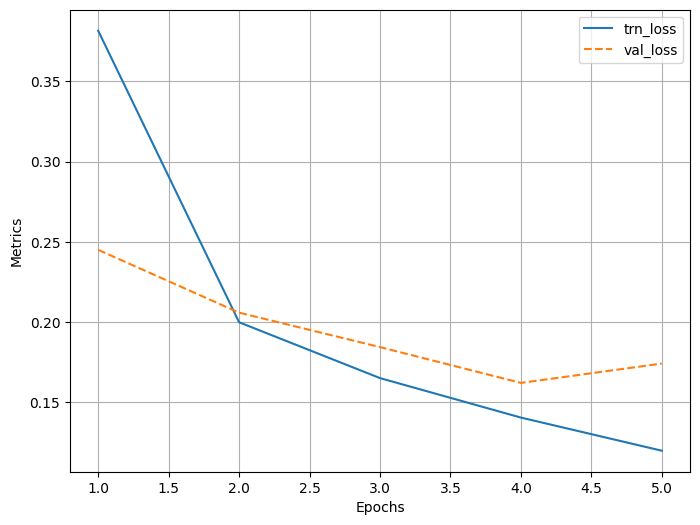

trn_loc_loss,█▆▄▂▄▄▄▄▃▃▁▂▂▃▂▁▁▃▁▂▁▂▃▃▂▁▂▃▁▁▂▁▁▂▁▁▂▁▁▁
trn_loss,▇█▆▂▅▄▅▅▆▄▁▃▂▄▃▂▂▄▂▄▁▂▃▃▂▂▂▄▁▁▃▂▁▄▂▂▂▁▁▁
trn_loss_objectness,▂█▆▁▄▂▁▅▆▃▂▁▁▂▂▁▂▃▁▂▁▁▁▂▁▂▂▂▂▁▃▂▂▁▁▃▁▁▁▂
trn_loss_rpn_box_reg,▃▄▂▂█▄▄▃▅▆▁▄▃▄▅▃▂▄▁▄▂▂█▂▂▃▃▅▁▁▂▃▁▃▃▂▁▃▁▃
trn_regr_loss,▆█▆▂▅▄▅▅▇▄▁▄▃▄▄▂▂▄▂▆▁▂▄▂▃▂▃▅▂▁▃▃▁▅▂▃▂▁▁▁
val_loc_loss,▂▄▅▃▇▁█▂▅▅▂▂▂▅▃▅▃▃▂▃▄▅▂▁▅▄▂▁▁▂▆▃▂▆▁▁▂▂▅▃
val_loss,▂▄▅▂█▂█▂▄▅▂▂▁▅▅▅▃▂▂▃▄▄▂▂▆▄▄▁▁▂▅▄▂▅▂▁▂▂▅▃
val_loss_objectness,▂▃▂▁▅▂█▁▂▁▁▁▁▁▄▃▁▁▁▁▁▂▁▁▂▅▂▁▁▁▂▃▁▁▁▁▁▁▃▁
val_loss_rpn_box_reg,▁▄▃▃█▂▆▁▂▄▅▂▂▂▄▃▂▂▂▂▂▂▃▅▃▇▃▂▂▁▃▂▆▃▅▂▂▂▃▁
val_regr_loss,▂▄▅▂█▂▇▂▄▆▂▂▁▅▆▄▃▂▂▃▄▄▂▂▇▄▄▁▁▂▄▄▂▄▂▁▂▂▆▃
trn_loc_loss,0.03415


In [13]:
n_epochs = 5
log = Report(n_epochs)
# Inside training loop
for e in range(n_epochs):
    for i, batch in enumerate(tr_dl):
        N = len(tr_dl)
        loss, losses = train_batch(batch, model, optim)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = [losses[k] for k in
                                                                  ['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg']]
        log.record(e + (i+1)/N, trn_loss=loss.item(), trn_loc_loss=loc_loss.item(),
                   trn_regr_loss=regr_loss.item(), trn_loss_objectness=loss_objectness.item(),
                   trn_loss_rpn_box_reg = loss_rpn_box_reg.item())
        # Log metrics with wandb
        wandb.log({
            'trn_loss': loss,
            'trn_loc_loss': loc_loss,
            'trn_regr_loss': regr_loss,
            'trn_loss_objectness': loss_objectness,
            'trn_loss_rpn_box_reg': loss_rpn_box_reg
        })

    # Validation loop
    for i, batch in enumerate(val_dl):
        N = len(val_dl)
        loss, losses = validate_batch(batch, model.float(), optim)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = [losses[k] for k in
                                                                  ['loss_classifier', 'loss_box_reg',
                                                                   'loss_objectness', 'loss_rpn_box_reg']]
        log.record(e + (i+1)/N, val_loss=loss.item(), val_loc_loss=loc_loss.item(),
                   val_regr_loss=regr_loss.item(), val_loss_objectness=loss_objectness.item(),
                   val_loss_rpn_box_reg = loss_rpn_box_reg.item())
        # Log metrics with wandb
        wandb.log({
            'val_loss': loss,
            'val_loc_loss': loc_loss,
            'val_regr_loss': regr_loss,
            'val_loss_objectness': loss_objectness,
            'val_loss_rpn_box_reg': loss_rpn_box_reg
        })

    log.report_avgs(e+1)

    ##wandb.summary['test_accuracy'] = 0.8


log.plot_epochs(['trn_loss', 'val_loss'])
wandb.finish()

In [ ]:
from torchvision.ops import nms

def decode_output(output):
    bbs = output['boxes'].cpu().detach().numpy().astype(np.uint16)
    labels = np.array([targets2label[i] for i in output['labels'].cpu().detach().numpy()])
    confs = output['scores'].cpu().detach().numpy()
    idxs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    bbs, confs, labels = [tensor[idxs] for tensor in [bbs, confs, labels]]
    if len(idxs) == 1:
        bbs, confs, labels = [np.array([tensor]) for tensor in [bbs, confs, labels]]
    return bbs.tolist(), confs.tolist(), labels.tolist()

model.eval()
for i, (images, targets) in enumerate(val_dl):
    if i == 10: break
    images = [im for im in images]
    outputs = model(images)
    for i, output in enumerate(outputs):
        bbs, confs, labels = decode_output(output)
        show(images[i].cpu().permute(1,2,0), bbs=bbs, texts=labels, sz=5, text_sz=10)